In [ ]:
# default_exp funcs.file_io

In [ ]:
%load_ext autoreload
%autoreload 2

# File handling

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.utils import *
from tifffile import imread
from decode_fish.engine.microscope import Microscope
from decode_fish.engine.psf import crop_psf
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.dataset import *
from torch.utils.data import DataLoader
from collections.abc import MutableSequence

In [ ]:
#export
def load_model_state(model, path):
    """
    Loads the network parameters, the intensity parameters and the scaling into model given a path.
    """
    model_dict = torch.load(path)
    model.load_state_dict(model_dict['state_dict'])
    model.inp_scale = model_dict['scaling'][0]
    model.inp_offset = model_dict['scaling'][1]
    return model

In [ ]:
#export
def simfish_to_df(sim_file, frame_idx=0, int_fac=1.05):
    
    yxzi = []
    with open(sim_file) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    # Number calculated by taking into account their (or my?) normalization (by max and not by sum)
    if yxzi.shape[1] == 4:
        # PSF.max() | PSF.sum() | 3**3 (superres)  | PSF.max() | microscope scale
        # ints = yxzi[:,3] * 65535.0 * 156772560.0 / 27 / 65535.0 / 10000.0
        ints = yxzi[:,3] * 65535.0 / 100.0 / int_fac
    else:
        ints = np.ones_like(loc_idx)
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,1],
                       'y': yxzi[:,0], 
                       'z': yxzi[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': ints, 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})

    return df   


def matlab_fq_to_df(resfile, frame_idx=0):
    
    ind_dict = {'x':1, 'y':0, 'z':2, 'int':3, 'x_sig':6, 'y_sig':7, 'z_sig':8}
    
    yxzi = []
    with open(resfile) as f:
        read = False
        for line in f:
            if 'Pos_Y' in line: 
                read = True
                continue
            if 'SPOTS_END' in line: break
            if read: yxzi.append([float(s) for s in line.split()])

    yxzi = np.array(yxzi)#/px_size
    loc_idx = np.arange(len(yxzi))
    
    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': frame_idx,
                       'x': yxzi[:,ind_dict['x']],
                       'y': yxzi[:,ind_dict['y']], 
                       'z': yxzi[:,ind_dict['z']], 
                       'prob': np.ones_like(loc_idx), 
                       'int': yxzi[:,ind_dict['int']], 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': yxzi[:,ind_dict['x_sig']], 
                       'y_sig': yxzi[:,ind_dict['y_sig']], 
                       'z_sig': yxzi[:,ind_dict['z_sig']],
                       'comb_sig' : np.sqrt(yxzi[:,ind_dict['x_sig']]**2
                                              +yxzi[:,ind_dict['y_sig']]**2
                                              +yxzi[:,ind_dict['z_sig']]**2)})

    return df 

#export 
def load_sim_fish(basedir, mrna_lvl=200, shape='cell3D', exp_strength='strong', cell_nr=0, shift=[-38,-38,-110], int_fac=1.05):
    
    spec_dir = f'/mRNAlevel_{mrna_lvl}/{shape}/{exp_strength}/'
    img_path = sorted(glob.glob(basedir + spec_dir + 'w1*.tif'))[cell_nr]
    cellname = Path(img_path).name.split('.')[0]
#     print(name)
    img = load_tiff_image(img_path)
    gt_df = simfish_to_df(img_path.split('.')[0] + '.txt', int_fac=int_fac)
    fq_nog_df = fq_gmm_df = DF()
    if os.path.exists(basedir + '/_results_detection/'):
        nog_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_noGMM/' + cellname + '_res_NO_GMM.txt')
        gmm_path = Path(basedir + '/_results_detection/' + spec_dir + '/results_GMM/' + cellname + '_res_GMM.txt')

        if nog_path.is_file(): 
            fq_nog_df = simfish_to_df(nog_path, int_fac=int_fac)
            fq_nog_df = shift_df(fq_nog_df, shift)
        if gmm_path.is_file(): 
            fq_gmm_df = simfish_to_df(gmm_path, int_fac=int_fac)
            fq_gmm_df = shift_df(fq_gmm_df, shift)
        
    return img, gt_df, fq_nog_df, fq_gmm_df

#export
def big_fishq_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep=';',names=['z','y','x'], index_col=False)

    zyx = np.array(csv)
    loc_idx = np.arange(len(zyx))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': zyx[:,2],
                       'y': zyx[:,1], 
                       'z': zyx[:,0], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

def rsfish_to_df(file_str):
    
    csv = pd.read_csv(file_str,sep='  ',names=['x','y','z','?','??'], index_col=False)
    
    xyz = np.array(csv)
    loc_idx = np.arange(len(xyz))

    df = pd.DataFrame({'loc_idx': loc_idx,
                       'frame_idx': np.zeros_like(loc_idx),
                       'x': xyz[:,1],
                       'y': xyz[:,0], 
                       'z': xyz[:,2], 
                       'prob': np.ones_like(loc_idx), 
                       'int': np.ones_like(loc_idx), 
                       'int_sig': np.ones_like(loc_idx), 
                       'x_sig': np.ones_like(loc_idx), 
                       'y_sig': np.ones_like(loc_idx), 
                       'z_sig': np.ones_like(loc_idx)})
    
    return df

In [ ]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
img, gt_df, fq_nog_df, fq_gmm_df = load_sim_fish(basedir, 250, 'random', 'NR', 2)

(array([29., 51., 69., 62., 41., 18.,  9., 11.,  0.,  1.]),
 array([ 2.76709367,  3.5775725 ,  4.38805134,  5.19853017,  6.00900901,
         6.81948784,  7.62996668,  8.44044551,  9.25092434, 10.06140318,
        10.87188201]),
 <BarContainer object of 10 artists>)

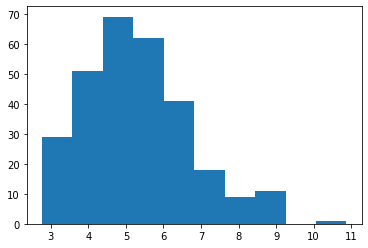

In [ ]:
plt.hist(gt_df['int'])

In [ ]:
# load_big_fishq('deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv')
f_name = '../../../deepstorm/datasets/CodFish/smFISH_data_Titlow/detections/sgg_smFISH_4_spots.csv'
tiff = load_tiff_image(Path(f_name).parent.parent/'sgg_smFISH_4.tif')
print(tiff.shape)

df = big_fishq_to_df(f_name)

torch.Size([1, 25, 512, 512])


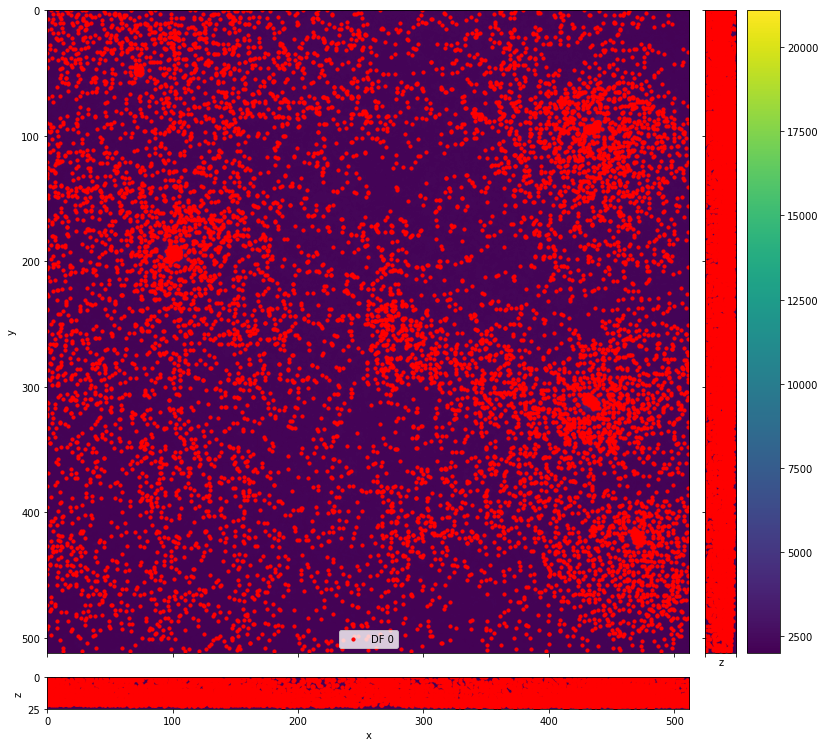

In [ ]:
from decode_fish.funcs.plotting import *
from decode_fish.funcs.emitter_io import *

fig, axes = plot_3d_projections(tiff[0], size=10)
scat_3d_projections(axes, [df])

In [ ]:
#export
def swap_psf_vol(psf, vol):
    state_dict = psf.state_dict()
    for i in range(len(state_dict['psf_volume'])):
        state_dict['psf_volume'][i] = torch.cuda.FloatTensor(torch.Tensor(vol).cuda())
    psf.load_state_dict(state_dict)
    return psf

def get_gaussian_psf(size_zyx, radii, pred_z, n_cols=1):
    
    if not pred_z:
        size_zyx[0] = 1
        
    if not isinstance(radii, MutableSequence):
        radii = 3*[radii]
    
    psf = LinearInterpolatedPSF(size_zyx, device='cuda', n_cols=n_cols)
    gauss_vol = gaussian_sphere(size_zyx, radii, [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    gauss_vol = gauss_vol/gauss_vol.max()
    
    psf = swap_psf_vol(psf, gauss_vol)
    return psf

psf = get_gaussian_psf([11,21,21], 0.2, True, 2)

def get_vol_psf(filename, device='cuda', psf_extent_zyx=None):
    
    if 'tif' in filename:
        psf_vol = load_tiff_image(filename)
        psf_vol = psf_vol/psf_vol.max()
        psf = LinearInterpolatedPSF(psf_vol.shape[-3:], device=device)
        psf = swap_psf_vol(psf, psf_vol)

    else:
        psf_state = torch.load(filename)
        psf = LinearInterpolatedPSF(psf_state['psf_volume'].shape[-3:], device=device)
        psf.load_state_dict(psf_state)

        if psf_extent_zyx:
            psf = crop_psf(psf,psf_extent_zyx)
            
    return psf

def load_psf(cfg):

    if cfg.data_path.psf_path:
        psf = get_vol_psf(cfg.data_path.psf_path,cfg.PSF.device, cfg.PSF.psf_extent_zyx)
    else:
        psf = get_gaussian_psf(cfg.PSF.psf_extent_zyx, cfg.PSF.gauss_radii, cfg.exp_type.pred_z, cfg.PSF.n_cols)
        
    return psf

def load_psf_noise_micro(cfg):
    
    psf = load_psf(cfg)
    noise = hydra.utils.instantiate(cfg.noise)
    if 'max' in cfg.microscope.norm:
        micro = hydra.utils.instantiate(cfg.microscope, psf=psf, noise=noise).cuda()
    else:
        micro = hydra.utils.instantiate(cfg.microscope, psf=psf, noise=noise, sum_fac=psf.psf_volume.sum().item()).cuda()
    return psf, noise, micro

def load_post_proc(cfg):
    if cfg.other.pp == 'si':
        return hydra.utils.instantiate(cfg.post_proc_si)
    if cfg.other.pp == 'isi':
        return hydra.utils.instantiate(cfg.post_proc_isi)
    
def get_dataloader(cfg):

    if  cfg.exp_type.name == 'smfish':
        if not cfg.exp_type.ch_to_batch:
            imgs_3d = [load_tiff_image(f)[cfg.exp_type.sm_fish_ch:cfg.exp_type.sm_fish_ch+1] for f in sorted(glob.glob(cfg.data_path.image_path))]
        else:
            imgs_3d = [load_tiff_image(f) for f in sorted(glob.glob(cfg.data_path.image_path))]     
            imgs_3d = [img.shape([-1,1,img.shape[-3],img.shape[-2],img.shape[-1]]) for img in imgs_3d]
    else:
        imgs_3d       = [load_tiff_image(f) for f in sorted(glob.glob(cfg.data_path.image_path))]
        
    roi_masks     = [get_roi_mask(img, tuple(cfg.roi_mask.pool_size), percentile= cfg.roi_mask.percentile) for img in imgs_3d]
    
    min_shape = tuple(np.stack([v.shape for v in imgs_3d]).min(0)[-3:])
    crop_zyx = (cfg.random_crop.crop_sz, cfg.random_crop.crop_sz,cfg.random_crop.crop_sz)
    if crop_zyx > min_shape:
        crop_zyx = tuple(np.stack([min_shape, crop_zyx]).min(0))
        print('Crop size larger than volume in at least one dimension. Crop size changed to', crop_zyx)
        
    gen_bg        = [hydra.utils.instantiate(cfg.bg_estimation.smoothing, z_size=crop_zyx[0])]
    
    if cfg.bg_estimation.fractal.scale:
        gen_bg.append(hydra.utils.instantiate(cfg.bg_estimation.fractal))
    
    rand_crop = RandomCrop3D(crop_zyx, roi_masks)

    probmap_generator = UniformValue(cfg.prob_generator.low, cfg.prob_generator.high)
    rate_tfms = [probmap_generator]
    
    dataset_tfms = [rand_crop]
    
    if cfg.foci is not None:
        if cfg.foci.n_foci_avg > 0:
            rate_tfms.append(hydra.utils.instantiate(cfg.foci))

    ds = DecodeDataset(volumes = imgs_3d,
                       dataset_tfms =  dataset_tfms, 
                       rate_tfms = rate_tfms, 
                       bg_tfms = gen_bg, 
                       device='cuda:0', 
                       num_iter=(cfg.training.num_iters) * cfg.training.bs) 

    decode_dl = DataLoader(ds, batch_size=cfg.training.bs, num_workers=0)
    
    return imgs_3d, decode_dl
    
def load_all(cfg):
    
    path = Path(cfg.output.save_dir)
    model = hydra.utils.instantiate(cfg.model)
    model = load_model_state(model, path/'model.pkl')
    post_proc = hydra.utils.instantiate(cfg.post_proc_isi, samp_threshold=0.5)
    _, noise, micro = load_psf_noise_micro(cfg)
    micro.load_state_dict(torch.load(path/'microscope.pkl'))
    img_3d, decode_dl = get_dataloader(cfg)
    
    return model, post_proc, micro, img_3d, decode_dl

In [ ]:
cfg = OmegaConf.load('../config/experiment/MERFISH_ci_2d_tffn2.yaml')
if 'n_cols' not in cfg.PSF:
    cfg.PSF.n_cols = 1
# cfg = OmegaConf.load(default_conf)
psf = load_psf(cfg)
# psf.load_state_dict(torch.load(Path(cfg.output.save_dir)/'psf.pkl'))

In [ ]:
imgs_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)


/groups/turaga/home/speisera/anaconda3/envs/decode2_dev/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


1 volumes


In [ ]:
from decode_fish.funcs.plotting import *
plot_3d_projections(psf.psf_volume[0])

NameError: name 'psf' is not defined

In [ ]:
size_zyx = [1,21,21]

vol_3d = []
facs = np.linspace(0.7,1.3,11)
for i in range(len(facs)):
    
    s = gaussian_sphere(size_zyx, [1.8,1.8*facs[i],1.8*facs[i]], [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    s = s/s.max()
    vol_3d.append(s)
    
vol_3d = np.concatenate(vol_3d,0)

In [ ]:
import tifffile
tifffile.imsave('../figures/MF_psf.tif', data=vol_3d)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted index.ipynb.
